<a href="https://colab.research.google.com/github/ebektur/Surface-Crack-Anomaly-Detection-using-ML/blob/main/EE417_Term_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction



Our problem is binary classification problem.

Transfer learning is a timesaving way by leveraging previous learnings. During our project, VGG is used as a pretrained model trained on a large dataset called ImageNet. VGG is based on convolutional neural networks (CNN). Feature extraction is done with the convolutional base of CNN and classifier is used for predicting if there is an anomaly of the given image or not. The first layers of the convolutional base (VGG in our case) that are closer to the inputs refers to general features whereas higher layers, which is the classifier refer to specialised features. 

Sculpturing the pre-trained model to function for anomaly detection required custom classifier. Fine tuning had performed by training some layers and leave others frozen of the VGG base. Learning rate in the convolutional part is set to adjust the weights of the network. **We used small learning rate to eliminate risk of losing previous knowledge. CNN weights are not distorted by the help of the learning rate. ** 

## Dataset Selection 

Crack surface detection dataset in Kaggle contains 40000 images, seperated to halves for positive and negative images for the existance of an anomaly. However, due to computational constraints, dataset is reduced to 10000. 80% of the images are used for training of the model, while 20% and 10% are used for testing and validation consecutively.

Our dataset is large and similar to the ImageNet dataset that is used for VGG base. According to Shu and Li, images' edges, textures, spaces and other feature information can be extracted rich and diverse image spatial feature information with ImageNet being the source data with its more than 1 million images. Although, the crack detection dataset contains 8000 images for training the model overcomes the worry of the overfitting, transfer learning becomes favorable option since ImageNet dataset provides spatial feature information that saves huge training effort. As a result, implying transfer learning, training classifier and the top layers of the convolutional base would be enough. 


Reference to ImageNet being perfect candidate:
####https://link.springer.com/article/10.1007/s13369-021-05963-3



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model,layers
import tensorflow as tf
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

import numpy as np 
import pandas as pd 
import os
import seaborn as sns

from keras import optimizers
from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from datetime import datetime

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16(input_shape = (150, 150,3), include_top=False, weights = "imagenet")

for layer in model.layers:
     layer.trainable = False

model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
#import os, os.path, shutil

#folder_path = "/content/drive/MyDrive/EE417/Negative"

#images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
#count = 0
#for image in images:
#  if(count < 500):
#    folder_name = image.split('.')[0]

#    new_path = "/content/drive/MyDrive/EE_417_dataset_small/validation/negative"
#    if not os.path.exists(new_path):
#        os.makedirs(new_path)

#    old_image_path = os.path.join(folder_path, image)
#    new_image_path = os.path.join(new_path, image)
#    shutil.move(old_image_path, new_image_path)
#    count = count + 1

In [ ]:
base_dir = '/content/drive/MyDrive/EE_417_dataset_small'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir,'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir,'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir,'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

## Data Visualization

In [ ]:
# Function that displays sample images from both classes for data exploration 

train_pos_dir = os.path.join(train_dir,'positive')
train_neg_dir = os.path.join(train_dir,'negative')


def load_sample_imgs(folder):
    imgs = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            imgs.append(img)
        if len(imgs)>3:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,5)
    
    for img,x in zip(imgs,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

Text(0.5, 1.0, 'Proportion of of Anomaly vs Normal Images in Train Directory')

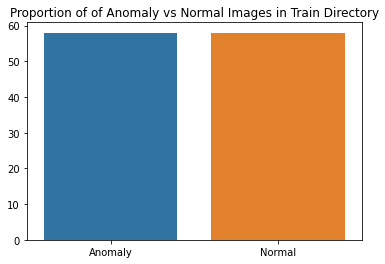

In [ ]:
sns.barplot(x=['Anomaly','Normal'], y=[len(train_pos_dir), len(train_neg_dir)])
plt.title('Proportion of of Anomaly vs Normal Images in Train Directory')

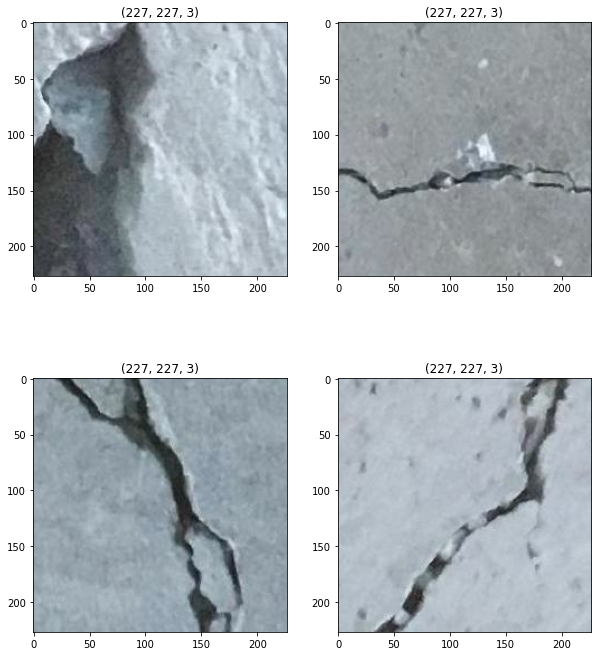

In [ ]:
load_sample_imgs(train_pos_dir)

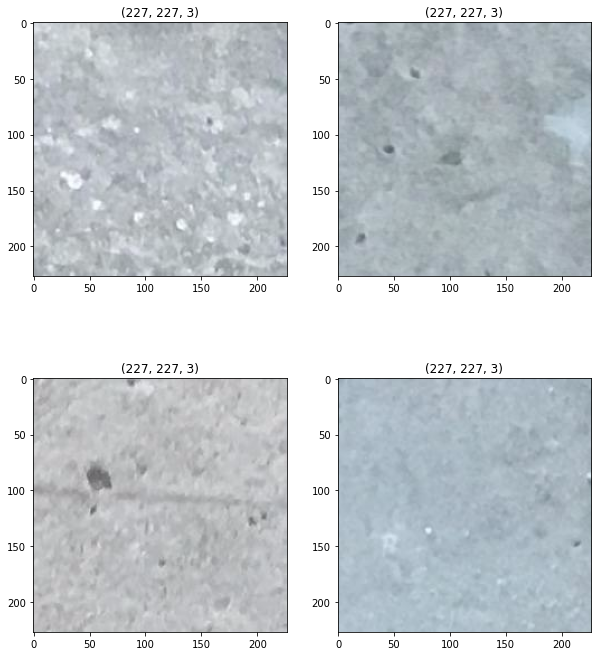

In [ ]:
load_sample_imgs(train_neg_dir)

In [ ]:
def canny_detector(folder):
    figure = plt.figure(figsize=(8,8))
    for filename in os.listdir(folder):
        img1 = cv2.imread(os.path.join(folder,filename))
        img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
        canny_img = cv2.Canny(img1,90,100)
    
        plt.xlabel(canny_img.shape)
        plt.ylabel(canny_img.size)
        plt.imshow(canny_img)
        break

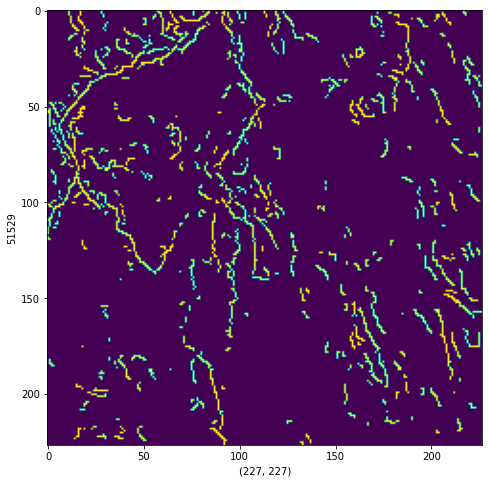

In [ ]:
canny_detector(train_pos_dir)

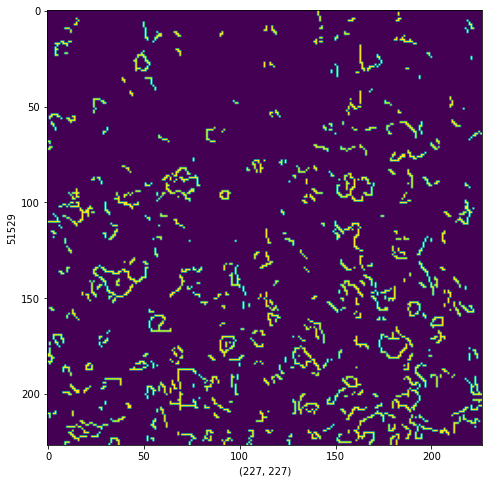

In [ ]:
canny_detector(train_neg_dir)

In [ ]:
#Thresholding: https://en.wikipedia.org/wiki/Thresholding_(image_processing)

def thresholding_func(folder):
    figure = plt.figure(figsize=(8,8))
    for filename in os.listdir(folder):
        img2 = cv2.imread(os.path.join(folder,filename))
        img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
        _,thr_img = cv2.threshold(img2,130,255,cv2.THRESH_BINARY_INV)
    
        plt.xlabel(thr_img.shape)
        plt.ylabel(thr_img.size)
        plt.imshow(thr_img)
        break

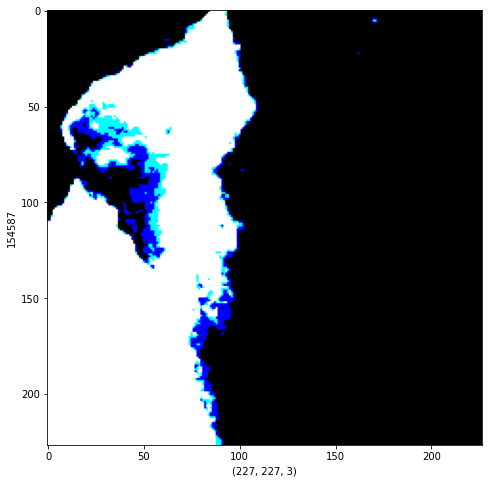

In [ ]:
thresholding_func(train_pos_dir)

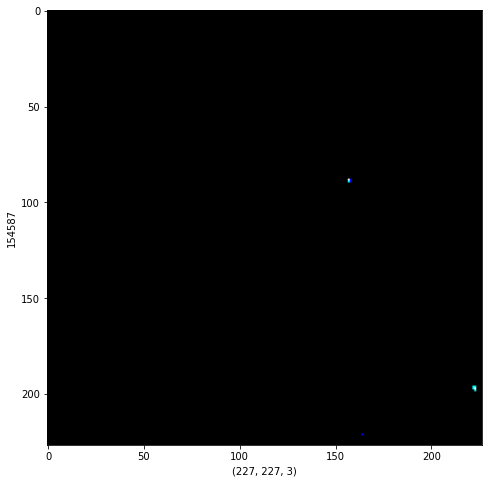

In [ ]:
thresholding_func(train_neg_dir)

## Model Training

Feature extraction will be done with the VGG model which will feed the classifiers to identify if surface images contains an anomaly or not. 

Several convergence methods have performed in training of the convolutional base for our model to learn better. 

Stochastic gradient descent approach is followed by arranging mini batches to speed up the learning. 

Mini-Batch size is chosen as 32 for several reasons. 

Gradient descent calculates error for each example and updates the model after all training examples are considered. 
When the batch size is large, it overcome the computation of the descent since it takes less samples into consideration and model may not converge at all. 

If the batch size is small, gradient descent will be calculated over smaller samples and this might be inefficient due to noise of the of the samples, however it usually results in convergence. 

Lastly, batch size should be chosen to be in favour of GPU because it is the power of two. 

Our model converges with the given epochs, which hints to correct selection of the batch size.


In [ ]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = train_datagen.flow_from_directory(directory,
                                            target_size=(150,150),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 7000)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 2000)

Found 7000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Choosing the best classifier

We have implemented three classifiers which are built with different approaches. As an output of these classifiers, anomaly existance will be detected. 

We compiled our classifier with the Adam optimization algorithm which is the extension of the stochastic graident descent that is  performed for the VGG base. 

For all three of the classifiers, we have set the learning rate 0.01, however the chosen classifier had tested further with the different learning rates.

All classifiers were trained with hundred epochs.

# Classifier is built by **fully-connected layers. **

Softmax activated layer follows the stack of fully-connected layer in our implementation. Softmax layer outputs probability distribution for each of the class labels. The highest probability value for in the prediction array refers to highest potential of the accurate labelling for the given image. Image is classified according to the most probable class pointed by the softmax layer.


In [ ]:

epochs = 100
start_time = datetime.now()
model_tune = models.Sequential()
model_tune.add(layers.Flatten(input_shape=(4,4,512)))
model_tune.add(layers.Dense(256, activation='relu', input_dim=(4*4*512)))
model_tune.add(layers.Dropout(0.5))
model_tune.add(layers.Dense(1, activation='sigmoid'))
model_tune.summary()
opt = Adam(lr=0.001)
# Compile model
model_tune.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history = model_tune.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

# do your work here
end_time = datetime.now()
print('Execution time for building fully connected layers: {}'.format(end_time - start_time))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


219/219 [==============================] - 5s 17ms/step - loss: 0.0376 - acc: 0.9859 - val_loss: 0.0282 - val_acc: 0.9900
Epoch 2/100
219/219 [==============================] - 4s 17ms/step - loss: 0.0220 - acc: 0.9926 - val_loss: 0.0186 - val_acc: 0.9930
Epoch 3/100
219/219 [==============================] - 4s 17ms/step - loss: 0.0126 - acc: 0.9974 - val_loss: 0.0302 - val_acc: 0.9900
Epoch 4/100
219/219 [==============================] - 4s 16ms/step - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0208 - val_acc: 0.9940
Epoch 5/100
219/219 [==============================] - 4s 16ms/step - loss: 0.0092 - acc: 0.9971 - val_loss: 0.0186 - val_acc: 0.9920
Epoch 6/100
219/219 [==============================] - 4s 17ms/step - loss: 0.0079 - acc: 0.9979 - val_loss: 0.0222 - val_acc: 0.9920
Epoch 7/100
219/219 [==============================] - 4s 16ms/step - loss: 0.0104 - acc: 0.9966 - val_loss: 0.0174 - val_acc: 0.9940
Epoch 8/100
219/219 [==============================] - 4s 16ms/step - loss

In [ ]:
from keras.models import load_model
model_tune = load_model('my_model.h5')

In [ ]:
#model_tune.save('my_model.h5')



Test accuracy is around 99.7% and loss is 5%, which is encouraging given the size of the dataset.
The model does not overfit. There’s a small gap between the training and the validation curves.
Since we already used dropout, we should increase the size of the dataset to improve the results.

The loss function is not decreasing when the model stops training. Probably, it is not possible to improve the model by increasing the number of epochs.


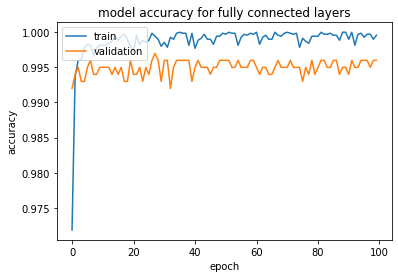

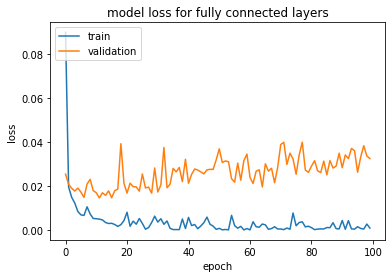

In [ ]:
# summarize history for accuracy for model_tune
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy for fully connected layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss for fully connected layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model_tune.evaluate(test_features, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.0542 - acc: 0.9970


[0.05419245734810829, 0.996999979019165]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def model_results(model, test_data, test_labels):
    
    results = model.evaluate(test_data, test_labels) 
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_labels, y_pred)
    clr = classification_report(test_labels, y_pred, target_names=['0', '1'])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["0", "1"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["0", "1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    return results

63/63 [==============================] - 0s 6ms/step - loss: 0.0482 - acc: 0.9970
    Test Loss: 0.04821
Test Accuracy: 99.70%


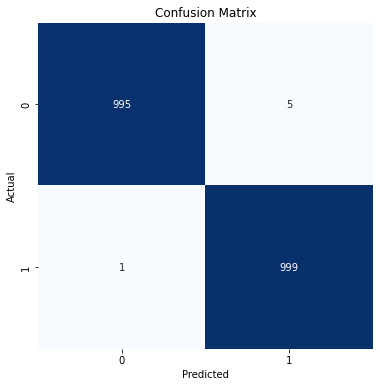

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [ ]:
result_tune = model_results(model_tune, test_features, test_labels)

In [ ]:
epochs = 100
start_time = datetime.now()
opt = Adam(lr=0.001)
batch_size = 32
model_pool = models.Sequential()
model_pool.add(layers.GlobalAveragePooling2D(input_shape=(4,4,512)))
model_pool.add(layers.Dense(1, activation='sigmoid'))
model_pool.summary()

# Compile model
model_pool.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['acc'])
              
# Train model
history_pool = model_pool.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

end_time = datetime.now()
print('Execution time for global average pooling: {}'.format(end_time - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
219/219 [==============================] - 1s 3ms/step - loss: 0.3679 - acc: 0.9390 - val_loss: 0.2481 - val_acc: 0.9600
Epoch 2/100
219/219 [==============================] - 1s 2ms/step - loss: 0.1757 - acc: 0.9771 - val_loss: 0.1555 - val_acc: 0.9770
Epoch 3/100
219/219 [==============================] - 1s 3ms/step - loss: 0.1162 - acc: 0.9836 - val_loss: 0.1139 - val

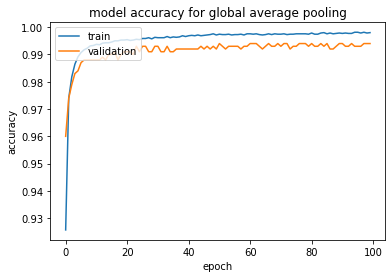

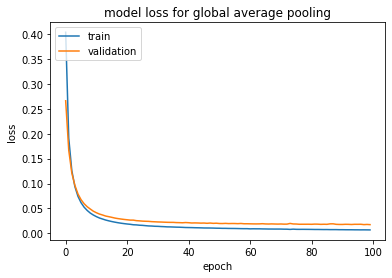

In [ ]:
# summarize history for accuracy for model_pool
plt.plot(history_pool.history['acc'])
plt.plot(history_pool.history['val_acc'])
plt.title('model accuracy for global average pooling')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pool.history['loss'])
plt.plot(history_pool.history['val_loss'])
plt.title('model loss for global average pooling')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model_pool.evaluate(test_features, test_labels)

63/63 [==============================] - 0s 2ms/step - loss: 0.0167 - acc: 0.9965


[0.01669786497950554, 0.9965000152587891]

In [ ]:
result_pool = model_results(model_pool, test_features, test_labels)

Test accuracy is 99.6% and loss is 1.67% similar to the one resulting from the fully-connected layers solution in terms of accuracy.

This model also proposes good solution since train and validation loss decrease and stabilize during the same epochs. 


# Linear support vector machine

In [ ]:
# Build model
import sklearn
from sklearn.svm import LinearSVC

svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))
X_train, y_train = svm_features.reshape(8000,4*4*512), svm_labels


In [ ]:
from sklearn.decomposition import PCA
start_time = datetime.now()
pca = PCA(n_components = 2).fit(X_train)
pca_2d = pca.transform(X_train)
svmClassifier = LinearSVC().fit(pca_2d, y_train)
end_time = datetime.now()
print('Execution time for support vector machine: {}'.format(end_time - start_time))

Execution time for support vector machine: 0:00:05.696926


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


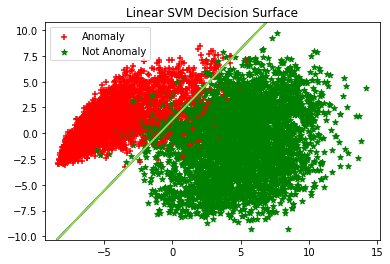

In [ ]:
import pylab as pl
c1 = 0
c2 = 0
for i in range(0, pca_2d.shape[0]):
  if svm_labels[i] == 0:
    c1 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='r', marker = '+')
  elif svm_labels[i] == 1:
    c2 = pl.scatter(pca_2d[i,0], pca_2d[i,1], c='g', marker = '*')
x_min, x_max = pca_2d[:,0].min() -1, pca_2d[:,0].max() + 1
y_min, y_max = pca_2d[:,1].min() -1, pca_2d[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))
Z = svmClassifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
pl.contour(xx,yy,Z)
pl.legend([c1, c2], ['Anomaly', 'Not Anomaly'],)
pl.title('Linear SVM Decision Surface')
pl.show()



In [ ]:
reshape_test = test_features.reshape(2000, 4*4*512)
pca_test = PCA(n_components = 2).fit(reshape_test)
pca_test_2d = pca.transform(reshape_test)
y_pred2 = svmClassifier.predict(pca_test_2d)
y_test2 = test_labels
print("Accuracy of the linear SVM solution:",metrics.accuracy_score(y_test2, y_pred2))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test2, y_pred2))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test2, y_pred2))


Accuracy of the linear SVM solution: 0.9605
Precision: 0.960960960960961
Recall: 0.96


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

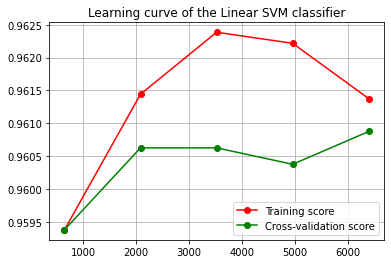

In [ ]:
from sklearn.model_selection import learning_curve
(train_sizes, train_scores,test_scores) = learning_curve(svmClassifier, pca_2d, y_train, cv=5)
test_mean = np.mean(test_scores, axis=1)
#plt.plot(train_sizes, test_mean, label="Cross-validation score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Learning curve of the Linear SVM classifier")

    # Plot learning curve
plt.grid()

plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
plt.legend(loc="best")




According to our three approaches, we found accuracies of 99.7, 99.6, and 96.0 for fully connected layers, global average pooling and support vector machines respectively. Although it arises the suspicions on overfitting with very high accuracies, this is due to our problem is deterministic; which focuses on if there is an anomaly or not. 

Our dataset contains classes that has similar in such a way that they are all white surfaces. However, they are different in terms of the existance of the cracks on the surfaces.

In support of this, we also proposed a balanced dataset where we have equal number of surfaces with and without cracks. This results in equal share in prediction of "YES" or "NO". Therefore, there is a high baserate in our model's training as well. 

We will validate our models in the upcoming chapter.

## Model Evaluation

We used cross validation to determine if there is an underfitting or overfitting. We used Gaussian Mixture Model with obtained clusters if they actual clusters from our dataset. 

By the help of skicit's own implementation, we compared covariance matrices with various shapes and compare how accuracies will change accordingly, to prevent if there is a potential overfitting on the dataset.




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

digits = load_digits()
X, y = digits.data, digits.target
for i in [GaussianNB(), SVC(gamma=0.001)]:
    (train_sizes,
     train_scores,
     test_scores) = learning_curve(i, X, y, cv=5)
    test_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, test_mean, label="Cross-validation score")

plt.legend()
plt.show()

**StratifiedKFold**

Takes group information into account to avoid building folds with imbalanced class distributions (for binary or multiclass classification tasks).

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(train_features, train_labels)

for train_index, test_index in skf.split(train_features, train_labels):
  X_train2, X_test2 = train_features[train_index], train_features[test_index]
  y_train2, y_test2 = train_labels[train_index], train_labels[test_index]


In [ ]:
X_train2 = X_train2.reshape(3500,4*4*512)
X_test2 = X_test2.reshape(3500,4*4*512)

In [ ]:
colors = ["turquoise", "darkorange"]
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        print(gmm.covariances_[n])
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

0.0042616083073353855
0.023397105448517926
[6.00054450e-02 1.00000000e-06 3.24925275e-02 ... 1.39838870e-03
 4.42064497e-02 1.00000000e-06]
[1.25344930e-03 1.00000000e-06 1.00000000e-06 ... 1.00000000e-06
 6.24674372e-03 1.00000000e-06]
[ 0.0574007   0.          0.00961197 ... -0.00029796 -0.00105985
  0.        ]
[0.e+00 1.e-06 0.e+00 ... 0.e+00 0.e+00 0.e+00]
[[ 7.55996920e-02  0.00000000e+00  1.51641038e-02 ... -2.30017853e-04
   4.43210068e-03  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-06  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.51641038e-02  0.00000000e+00  4.36427698e-02 ... -2.14315611e-04
   1.09438135e-02  0.00000000e+00]
 ...
 [-2.30017853e-04  0.00000000e+00 -2.14315611e-04 ...  1.96026794e-03
   1.01373748e-03  0.00000000e+00]
 [ 4.43210068e-03  0.00000000e+00  1.09438135e-02 ...  1.01373748e-03
   5.20483550e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e-06]]


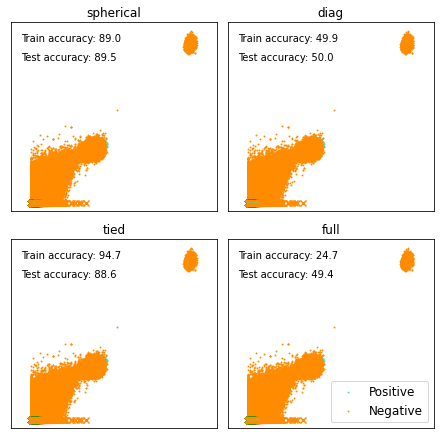

In [ ]:
#https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py
model_history = [] 

train_labels_ = ["Positive", "Negative"]
estimators = { 
    cov_type: GaussianMixture(
        n_components=2, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}
n_estimators = len(estimators)
plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train2[y_train2 == i].mean(axis=0) for i in range(2)]
    )

    # Train the other parameters using the EM algorithm.
    result = estimator.fit(X_train2)
    model_history.append(result)
    
    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = train_features[train_labels == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=train_labels_[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test2[y_test2 == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train2_pred = estimator.predict(X_train2)
    train_accuracy = np.mean(y_train2_pred.ravel() == y_train2.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test2_pred = estimator.predict(X_test2)
    test_accuracy = np.mean(y_test2_pred.ravel() == y_test2.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()

[GaussianMixture(covariance_type='spherical', max_iter=20,
                 means_init=array([[1.92901553e-01, 0.00000000e+00, 5.43747529e-03, ...,
         8.22413819e-05, 6.37857811e-01, 0.00000000e+00],
        [3.18996402e-01, 0.00000000e+00, 8.56420312e-02, ...,
         8.09382390e-03, 7.22015145e-01, 0.00000000e+00]]),
                 n_components=2, random_state=0),
 GaussianMixture(covariance_type='diag', max_iter=20,
                 means_init=array([[1.92901553e-01, 0.00000000e+00, 5.43747529e-03, ...,
         8.22413819e-05, 6.37857811e-01, 0.00000000e+00],
        [3.18996402e-01, 0.00000000e+00, 8.56420312e-02, ...,
         8.09382390e-03, 7.22015145e-01, 0.00000000e+00]]),
                 n_components=2, random_state=0),
 GaussianMixture(covariance_type='tied', max_iter=20,
                 means_init=array([[1.92901553e-01, 0.00000000e+00, 5.43747529e-03, ...,
         8.22413819e-05, 6.37857811e-01, 0.00000000e+00],
        [3.18996402e-01, 0.00000000e+00, 8.56420

In [ ]:
print(history.history.keys())

## Model Comparison

In [ ]:
output = pd.DataFrame({'Model':['model_tune','model_pool'],
                      'Accuracy':[result_tune[1], result_pool[1]]})

In [ ]:
output

In [ ]:
sns.barplot(x='Accuracy', y='Model', data=output)